### Sentiment Analysis and Topic Modeling for Product Reviews

<b>Project Summary:</b> This project aims to build a basic sentiment analysis functionality to ascertain whether product reviews are positive or negative. Time permitting, this project also has a secondary goal: to analyze the negative reviews for a subset of the products (in particular, Apple iphones) to assess if we can determine any themes or common topics emerging.

<b>What is sentiment analysis?</b> Sentiment analysis is a growing genre of text analysis that aims to assess the tone or emotion, a.k.a sentiment, associated with text. It gained a lot of mainstream attention in 2020, when stock analysts were especially interested in mining posts from popular subreddits such as r/wallstreetbets to try ascertain the retail investor sentiments about meme stocks via their posts, as thus, predict their potential trading actions. While main state of the art packages exist for sentiment analysis today, this project is meant to serve only as an intro to this field.

<b>What is topic modeling?</b> Topic modeling aims to create coherent groupings of words to glean common themes ("topics") from the text corpus.

<b>Dataset and Technology:</b> The dataset is an extract of ~400K reviews of various various products (predominantely electronics) from Amazon. This project is executed in Python, using predominantly the nltk/spacy and sklearn libraries. Two vectorizers - CountVectorizer and TfidfVectorizer and three sklearn models - multinomial naivebaiyes, logistic regression and random forest classifiers, are explored. Gridsearch based parameter tuning is performed to determine the optimal number of features and other parameters for the vectorizers and each of the models.

* [Sentiment Analysis](#sen)
     1. [Part 1: Creating the relevant datasets](#part1)
     2. [Part 2: Building the base vectorizers](#part2)
     3. [Part 3: GirdSearch based paramter selection using Multinomial Naive Baiyes](#part3)
     4. [Part 4: Logistic Regression](#part4)
     5. [Part 5: Random Forest Classifier](#part5)
     6. [Part 6: VADER](#part6)
     7. 
#####
* [Topic Modeling](#top) Pending

##
#### Data Loading and Initial Processing
We start by importing the necessary libraries and loading our dataset. Our columns of interest in the dataset are "Reviews" (text review) and "Ratings" (numerical ratings from 1-5). Duplicates review/rating combinations or missing valies are dropped and "ratings" are converted to rudimentary placeholders for "sentiments" by treating any rating above 3 as a positive sentiment and any rating below 3 as a negative sentiment. For this initial version we are only considering binary classification so neutral sentiments are ignored (rating of 3) but it could be easily included in a multi class classifcation model.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import time
np.random.seed(0)

In [2]:
##basic data cleaning
df_full = pd.read_csv("Amazon_Reviews.zip")
df_full.info()
# df_full.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413770 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [3]:
##since the focus the Review and Rating columns, any rows with missing values are dropped
df_full.dropna(subset = ["Reviews", "Rating"], axis = 0, inplace = True)
print(df_full.shape) #(413770, 6)
df_full.sample(2)

(413770, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
30147,Apple iPhone 5c 32GB (Blue) - Verizon Wireless,Apple,103.94,5,I am very happy with the phone!!,0.0
62159,"Apple iPhone 6, Gold, 128 GB (Verizon)",Apple,119.99,5,Awesome phone! No complaints.,0.0


####
#### <a name="sen">Goal 1: Sentiment Analysis </a>
##### <a name="part1">Part 1: Creating the relevant datasets</a>
Since the focus in this introductory project is postive vs negative sentiment analysis only, all neutral reviews (rating =3) are excluded. The dataset is then split into a training and test set per the typical model development steps. All further modeling/vectorization is performed on the training set only and the test rest is reserved for model evaluation. Note, our dataset is imbalanced (as shown below in Fig. 1), when evaluating the model, accuracy scores can skew towards the dominant class. To avoid this, all evaluation is performed using the f1 score. 

In [8]:
##dropping neutral reviews for now since the initial focus is on postive (rating >3) or negative (rating <3) sentiments; 
##creating the label "sentiment" from the more granular Rating column
df_sen = df_full[df_full.Rating != 3][["Reviews", "Rating"]]
print(df_sen.shape) #(382007, 6)
df_sen["Sentiment"] = np.where(df_sen.Rating >3,1,0)

df_sen.sample(2)

(382007, 2)


,Reviews,Rating,Sentiment
320238,Great product!!! I bought this phone in my war...,5,1
108499,redy,5,1


In [9]:
df_sen = df_sen[["Reviews", "Sentiment"]]

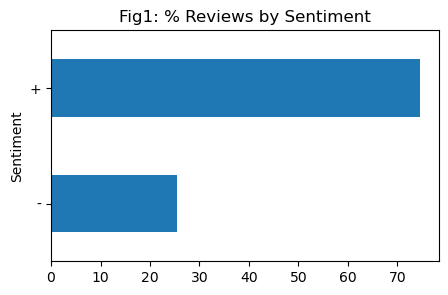

In [14]:
_ = round(df_sen.Sentiment.value_counts()/df_sen.shape[0]*100,2).sort_index()
_.plot(kind = "barh", title = "Fig1: % Reviews by Sentiment", figsize = (5,3));
plt.yticks(ticks=[0,1], labels=['-', '+']);

In [12]:
##creating the training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df_sen.Reviews, df_sen.Sentiment, stratify = df_sen.Sentiment)
print(f" The training set has {X_train.shape[0]} records and the test set has {X_test.shape[0]}")
# X_train.sample(3)
# y_train.value_counts()/y_train.shape[0]

 The training set has 286505 records and the test set has 95502


#####
##### <a name="part2">Part 2: Building the base vectorizers</a>
Since text data cannot be used directly for predictive modeling, it is first converted into numerical form via vectorization. Two vectorizers are considered, CountVectorizer, which is a frequency based vectorizer that records the counts of each word, and the TfidfVectorizer where the word counts are normalized such that more frequent words (which do not add much additional meaning) are excluded), thus potentially simplifying the vectorizer.

Hyperparameters for each of these vectorizers are tuned via the gridsearch function below and the performance of each is evaluated using a Multinomale Naive Bayes model as a baseline.

In [31]:
##tokenizing and vectorizing the text in the reviews
cvec =  CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b") #excluding numeric/alphanumeric tokens
tfvec = TfidfVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b") 

def grid_search(pipe, params):
    gs = GridSearchCV(pipe, param_grid = params, scoring = "f1")
    gs.fit(X_train, y_train)
    return gs
    
##useful links
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html

#####
##### <a name="part3">Part 3: GirdSearch based paramter selection using Multinomial Naive Baiyes</a>
##### (A) Multinomial NaiveBayes with CountVectorizer

In [55]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

start_time = time.time()
pipe = Pipeline([('v', cvec),('mnb', MultinomialNB())])
params = {"v__min_df": [5, 10, 25, 50], #higher threshold does add much value in prior tests
          "v__max_df":[.5, .75, .9], #lower thresholds dont add much value in prior tests
          # "v__max_features": [1000, 10000, 50000], #better results using all features
          "v__ngram_range": [(1,1), (1,2)]} 
nbcv = grid_search(pipe, params) #implements f1 scoring within function
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #7mins

# gs.cv_results_.keys()
nbcv_results = pd.DataFrame(nbcv.cv_results_).sort_values("rank_test_score").reset_index()
nbcv_results.to_csv('nbcv_gridsearch_results.csv')
nbcv_results[["param_v__max_df", "param_v__min_df", "param_v__ngram_range", 
                 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_v__max_df,param_v__min_df,param_v__ngram_range,mean_test_score,std_test_score,rank_test_score
0,0.5,5,"(1, 2)",0.960595,0.000288,1
1,0.75,5,"(1, 2)",0.960595,0.000288,1
2,0.9,5,"(1, 2)",0.960595,0.000288,1
3,0.75,10,"(1, 2)",0.956157,0.000268,4
4,0.9,10,"(1, 2)",0.956157,0.000268,4
5,0.5,10,"(1, 2)",0.956157,0.000268,4
6,0.5,25,"(1, 2)",0.950777,0.000491,7
7,0.75,25,"(1, 2)",0.950777,0.000491,7
8,0.9,25,"(1, 2)",0.950777,0.000491,7
9,0.9,50,"(1, 2)",0.947591,0.000520,10


In [56]:
print(f"The model has {len(nbcv.best_estimator_['v'].get_feature_names_out())} parameters")
print(f"AUC score on test set: {roc_auc_score(nbcv.best_estimator_.predict(X_test), y_test).round(2)}")
print(f"F1 score on test set: {f1_score(nbcv.best_estimator_.predict(X_test), y_test).round(2)}")

The model has 192677 parameters
AUC score on test set: 0.93
F1 score on test set: 0.96


<b>Key observations:</b>
- Bigrams appear to perform better than unigrams
- min_df 5 and max_df at 0.75 should be fine
- Final number of features is very large, which in practical terms may be overkill; assessing the impact of dropping the number of features below
####

In [60]:
##to assess the impact of reducing the number of features - running this together with the first girdsearch was taking too long on my local machine
cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 5, max_df = 0.75, ngram_range = (1,2)) 
params = {"v__max_features": [100, 500, 1000, 5000, 10000, 50000, 100000]} 

start_time = time.time()
pipe = Pipeline([('v', cvec),('mnb', MultinomialNB())])
nbcv2 = grid_search(pipe, params) #implements f1 scoring within function
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #5mins
nbcv_results2 = pd.DataFrame(nbcv2.cv_results_).sort_values("rank_test_score").reset_index()
nbcv_results2.to_csv('nbcv_gridsearch_results_features.csv')
nbcv_results2[["param_v__max_features", 'mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 6.42


,param_v__max_features,mean_test_score,std_test_score,rank_test_score
0,100000,0.958510,0.000239,1
1,50000,0.954928,0.000466,2
2,10000,0.947321,0.000500,3
3,5000,0.944113,0.000616,4
4,1000,0.935139,0.000472,5
5,500,0.927889,0.000780,6
6,100,0.899345,0.000956,7


#####
##### (B) Multinomial NaiveBayes with TfidfVectorizer

In [62]:
start_time = time.time()
pipe = Pipeline([('v', tfvec),('mnb', MultinomialNB())])
params = {"v__min_df": [5, 10, 25, 50], #higher threshold does add much value in prior tests
          "v__max_df":[.5, .75, .9], #lower thresholds dont add much value in prior tests
          # "v__max_features": [1000, 10000, 50000], #better results using all features
          "v__ngram_range": [(1,1), (1,2)]} 
nbtf = grid_search(pipe, params)
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #14mins

nbtf_results = pd.DataFrame(nbtf.cv_results_).sort_values("rank_test_score").reset_index()
nbtf_results.to_csv('nbtf_gridsearch_results.csv')
nbtf_results[["param_v__max_df", "param_v__min_df", "param_v__ngram_range", 
                 'mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 13.95


,param_v__max_df,param_v__min_df,param_v__ngram_range,mean_test_score,std_test_score,rank_test_score
0,0.5,5,"(1, 2)",0.959686,0.000624,1
1,0.75,5,"(1, 2)",0.959686,0.000624,1
2,0.9,5,"(1, 2)",0.959686,0.000624,1
3,0.75,10,"(1, 2)",0.957625,0.000384,4
4,0.9,10,"(1, 2)",0.957625,0.000384,4
5,0.5,10,"(1, 2)",0.957625,0.000384,4
6,0.5,25,"(1, 2)",0.952916,0.000478,7
7,0.75,25,"(1, 2)",0.952916,0.000478,7
8,0.9,25,"(1, 2)",0.952916,0.000478,7
9,0.9,50,"(1, 2)",0.949251,0.000576,10


In [63]:
print(f"The model has {len(nbtf.best_estimator_['v'].get_feature_names_out())} parameters")
print(f"AUC score: {roc_auc_score(nbtf.best_estimator_.predict(X_test), y_test).round(2)}")
print(f"F1 score: {f1_score(nbtf.best_estimator_.predict(X_test), y_test).round(2)}")

The model has 192677 parameters
AUC score: 0.94
F1 score: 0.96


In [64]:
tfvec = TfidfVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 5, max_df = 0.75, ngram_range = (1,2)) 
params = {"v__max_features": [100, 500, 1000, 5000, 10000, 50000, 100000]} 

start_time = time.time()
pipe = Pipeline([('v', tfvec),('mnb', MultinomialNB())])
nbtf2 = grid_search(pipe, params) #implements f1 scoring within function
print(f"Runtime: {round((time.time()-start_time)/60, 2)}") #6.5mins
nbtf_results2 = pd.DataFrame(nbtf2.cv_results_).sort_values("rank_test_score").reset_index()
nbtf_results2.to_csv('nbtf_gridsearch_results_features.csv')
nbtf_results2[["param_v__max_features", 'mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 6.54


,param_v__max_features,mean_test_score,std_test_score,rank_test_score
0,100000,0.959495,0.000557,1
1,50000,0.956296,0.000319,2
2,10000,0.948697,0.000537,3
3,5000,0.945730,0.000637,4
4,1000,0.935212,0.000571,5
5,500,0.926916,0.000768,6
6,100,0.897100,0.001026,7


<b>Key Observation:</b> Both the Countvectorizer and the Tfidf vectorizer perform nearly the same. To speed up processing, for other classification models, we use CountVectorizer with the parameters determined above and a max of 10Kfeatures
#### 

In [29]:
# y_train.shape #(286505,)
# y_train.value_counts()/y_train.shape[0] #1 - 75%, 0-25%

cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 50, max_df = 0.75, max_features = 10000, ngram_range = (1,2))
X_train_cv = cvec.fit_transform(X_train)

##Addressing Data Imbalance
##https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
##https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
X_train_cv_res, y_train_res = RandomOverSampler().fit_resample(X_train_cv, y_train)
# print(y_train_res.value_counts()/y_train_res.shape[0]) #50%each
# print(y_train_res.shape)#(427422,)

model = MultinomialNB().fit(X_train_cv_res, y_train_res)
print(f"AUC score on test set: {roc_auc_score(model.predict(cvec.transform(X_test)),y_test).round(2)}") #.88
print(f"F1 score on test set: {f1_score(model.predict(cvec.transform(X_test)),y_test).round(2)}") #.94

AUC score on test set: 0.87
F1 score on test set: 0.94


#####
##### <a name="part4">Part 4: Logistic Regression with CountVectorizer</a>

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

params = {"lr__C": [0.1, 0.5, 1.0]} 
cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 50, max_df = 0.75, max_features = 10000, ngram_range = (1,2))
start_time = time.time()
pipe = Pipeline([('v', cvec),('lr', LogisticRegression(max_iter = 1000))])
lrcv = grid_search(pipe, params)
print(f"Runtime: {round((time.time()-start_time)/60, 2)}")

lrcv_results = pd.DataFrame(lrcv.cv_results_).sort_values("rank_test_score")
lrcv_results[['params','mean_test_score', 'std_test_score', 'rank_test_score']]

Runtime: 4.36


,params,mean_test_score,std_test_score,rank_test_score
2,{'lr__C': 1.0},0.962692,0.000232,1
1,{'lr__C': 0.5},0.961422,0.000409,2
0,{'lr__C': 0.1},0.956629,0.000455,3


In [38]:
lrcv_results.to_csv('lrcv_gridsearch_results.csv')
print(f"AUC score: {roc_auc_score(lrcv.best_estimator_.predict(X_test), y_test).round(2)}")
print(f"F1 score: {f1_score(lrcv.best_estimator_.predict(X_test), y_test).round(2)}")

AUC score: 0.94
F1 score: 0.96


#####
##### <a name="part5">Part 5: RandomForestClassifier with CountVectorizer</a>

In [42]:
##https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

cvec = CountVectorizer(stop_words = 'english', lowercase = True, token_pattern = r"\b[A-Za-z]{3,}\b",
                       min_df = 50, max_df = 0.75, max_features = 10000, ngram_range = (1,2))
start_time = time.time()
pipe = Pipeline([('v', cvec),('lr', RandomForestClassifier(max_depth = 10))])

rfcv = pipe.fit(X_train, y_train)
print(f"Runtime: {round((time.time()-start_time)/60, 2)}")

print(f"AUC score: {roc_auc_score(rfcv.predict(X_test), y_test).round(2)}")
print(f"F1 score: {f1_score(rfcv.predict(X_test), y_test).round(2)}")

Runtime: 0.28
AUC score: 0.87
F1 score: 0.86


##### 
##### <a name="part6">Part 6: Test case</a>

In [39]:
test = ["Its the best", "Its the worst", "Its not the best", "Its not the worst"]
lrcv.predict(test)
# model.predict(cvec.transform())

array([1, 0, 1, 0])

#### <a name="top">Topic Modeling </a>
Pending

In [15]:
####
##### Creating the dataset for topic modeling
# For this project topic modeling focus on negative reviews only and is limited to one product. By narrowing the scope, we aim to try to extract main themes of complains/concerns mentioned in the reviews

df_top = df_full[
                (df_full["Rating"].isin([1, 2])) & 
                (df_full["Brand Name"] == "Apple") &
                (df_full["Product Name"].str.contains("Apple iPhone"))][["Brand Name", "Product Name", "Rating", "Reviews"]]
print(df_top.shape)
df_top.sample(2)

(12705, 4)


,Brand Name,Product Name,Rating,Reviews
48078,Apple,"Apple iPhone 5s AT&T Cellphone, 16GB, Gold",2,"I Can not activate it,I call apple customer te..."
31136,Apple,Apple iPhone 5c 32GB (Green) - Verizon Wireless,1,Great seller took back quickly. Phone like man...
